In [7]:
import tensorflow as tf
import time

tf.data API로 만들어진 데이터셋은 한 단계가 종료되기 전에 다음 스텝의 데이터를 운반할 수 있다. 그렇기 때문에 데이터를 그냥 사용하는 것보다 유연하고 효율적인 파이프라인 구성이 가능하다.

그렇다면, 그냥 데이터셋과 tf.data.Dataset 개체와 성능에 어떤 차이가 있는지 객관적으로 비교해보고 더 좋은 것을 택할 수 있을 것이다.

## 데이터셋

In [8]:
# 인공 데이터셋 생성
class ArtificialDataset(tf.data.Dataset):
    def _generator(num_samples):
        # 데이터셋의 생성자에 들어갈 기본 설정. 실제 생성은 아래 __new__메서드에서 수행
        # 파일 열기 - 잠시 대기를 줌
        time.sleep(0.03)
        
        for sample_idx in range(num_samples):
            # (인덱스, 샘플(레코드)) 형태의 데이터 읽기
            time.sleep(0.015)
            
            yield (sample_idx,)
# yield : 제너레이터 객체를 반환하며, return과 비교했을 때 결과를 나눠서 받
# 을 수 있다는 장점이 있다. 결과를 하나씩 메모리에 올리기 때문에 효율적이다.
# 즉 위 코드의 생성자는 0.03초, 0.15초의 지연시간 후에 sample_idx를 하나씩 반환한다
    def __new__(cls, num_samples=3):
        return tf.data.Dataset.from_generator(cls._generator,
                                             output_signature=tf.TensorSpec(shape=(1,), dtype=tf.int64),
                                             args=(num_samples,))
    

tf.TensorSpec은 무슨 역할을 하는가?

API document 상에는 tf.Tensor의 타입을 서술한다고 쓰여있다.

In [10]:
tf.TensorSpec(shape=(1,))

TensorSpec(shape=(1,), dtype=tf.float32, name=None)

In [12]:
t = tf.constant([[1,2,3],[4,5,6]])
tf.TensorSpec.from_tensor(t)

TensorSpec(shape=(2, 3), dtype=tf.int32, name=None)

In [18]:
tf.TensorSpec

tensorflow.python.framework.tensor_spec.TensorSpec

그것은 Dataset의 from_generator 메서드가 output_signature를 통해 TensorSpec 개체로부터 output_shapes와 output_types를 한 번에 받기 때문이다.

즉, shape=(1,)이고 dtype=tf.float32인 텐서스펙을 매개변수로 삽입했을 뿐이다.

### 훈련 루프

그렇다면 이 데이터셋을 반복하는데는 어느 정도 시간이 걸리는가?

In [26]:
def benchmark(dataset, num_epochs=2):
    start_time = time.perf_counter()
    for epoch_num in range(num_epochs):
        for sample in dataset:
            time.sleep(0.01)
    print('Execution time:', time.perf_counter() - start_time)

In [27]:
benchmark(ArtificialDataset())

Execution time: 0.39281260000007023


### 프리페칭

tf.data.Dataset은 prefetch 변환을 통해 PrefetchDataset 개체로 만들 수 있다. 이 프리페치 데이터는 데이터의 생성과 소비를 분리하며, 미리 입력 데이터세트에서 요소를 가져올 수 있게 만든다.

In [28]:
benchmark(ArtificialDataset().prefetch(tf.data.AUTOTUNE))

Execution time: 0.29767360000005283


두 불러오는 방식에 어떤 차이가 있기에 프리페칭이 항상 더 데이터를 빨리 불러오는가?

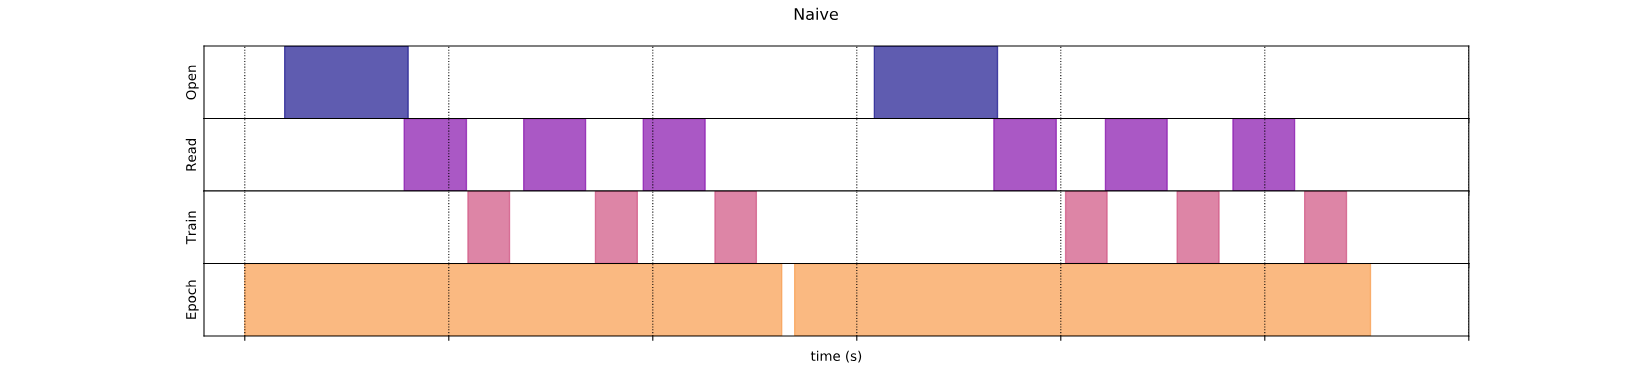

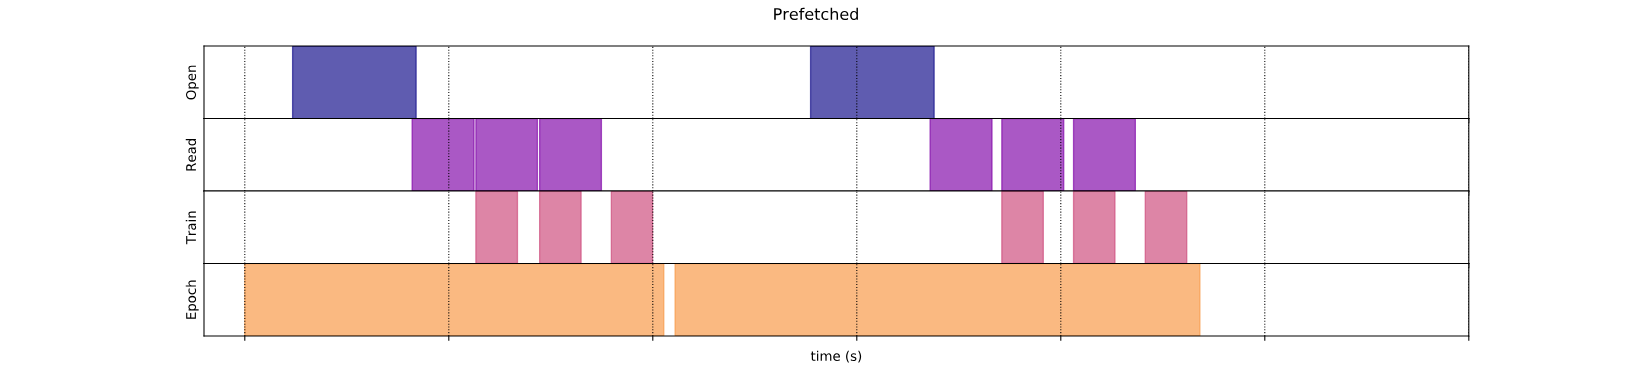

일반 데이터셋은 한 에폭 중에 데이터셋을 열고, 데이터를 읽고, 데이터를 훈련하는 시간이 분리되어 있다. 그렇기 때문에 훈련이 끝나야 다음 데이터를 읽어오는 특성 상, 한 훈련에서 다음 훈련까지의 지연시간이 길어질 수 밖에 없다.

하지만 데이터를 프리페칭하게 되면, 읽는 도중에 훈련하고, 훈련하는 도중에 데이터를 읽어온다. 즉, 앞의 방식보다 지연 시간이 짧아지게 된다.

### 데이터 추출 병렬화

입력 데이터가 로컬에서 사용하기 어렵거나, 학습 자체가 분산되어 있는 경우 (그리고 입력 데이터를 분산된 모든 환경에 복제하는 것은 적절하지 않기 때문에) 원격으로 데이터를 저장하고 사용할 수 있다.

하지만 원격으로 데이터를 읽을 때 입출력에 병목이 발생할 수 있다. 

    * 원격 저장소에서 파일의 첫 번째 바이트를 읽는 것은 로컬 저장소에서 읽는 것보다 훨씬 오래 걸린다. (Time-to-first-byte)
    * 원격 저장소는 큰 대역폭을 가지지만 파일을 읽을 때는 대역폭의 일부만 활용할 수 있다. (Read throughout)
    
또한 데이터를 역직렬화, 디코딩할 필요가 생길 수 있다. 이런 영향을 줄이기 위해 인터리브 변환을 사용한다. 

**인터리빙** : 주기억장치에 접근하는 속도를 빠르게 하기 위해, 데이터가 서로 인접하지 않도록 배열하는 방법

#### 순차적 인터리브

두 개의 데이터셋에서 단일 샘플을 순차적으로 로드

In [29]:
benchmark(tf.data.Dataset.range(2).interleave(lambda _: ArtificialDataset()))

Execution time: 0.7838689000000159


#### 병렬 인터리브

순차적으로 로드하지 않고, 병렬로 로드한다.

In [31]:
benchmark(tf.data.Dataset.range(2).interleave(lambda _: ArtificialDataset(),
                                             num_parallel_calls=tf.data.AUTOTUNE))

Execution time: 0.393286800000169


요는, 원격으로 데이터를 읽어올 경우, 인터리브를 통한 병렬 로딩으로 전역 데이터 처리 시간을 줄일 수 있다는 것이다. (벤치마킹을 통해 비교해보면 로컬의 경우 프리페치 로딩이 더 빠르다)

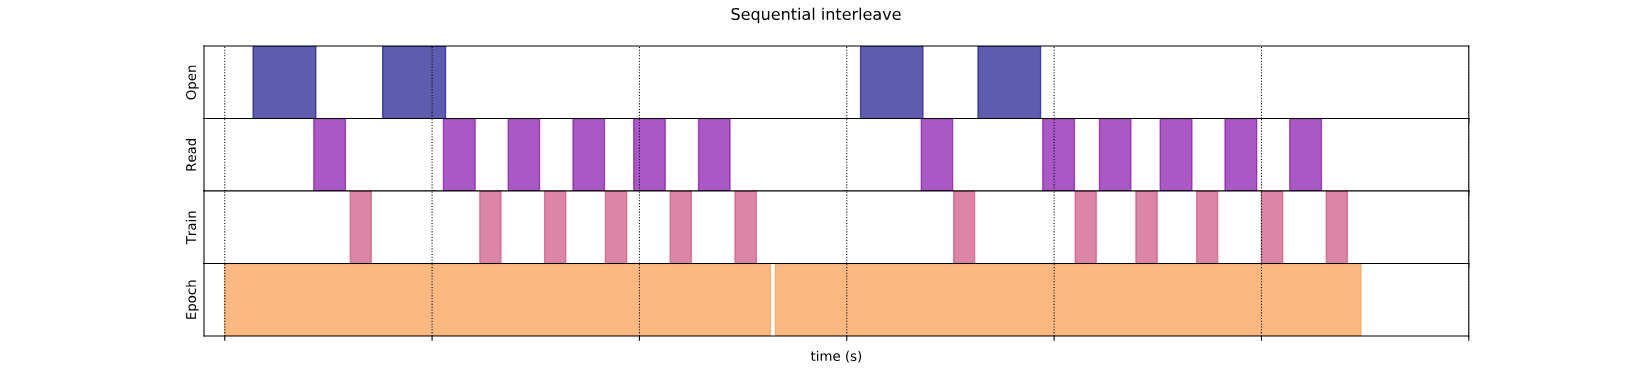
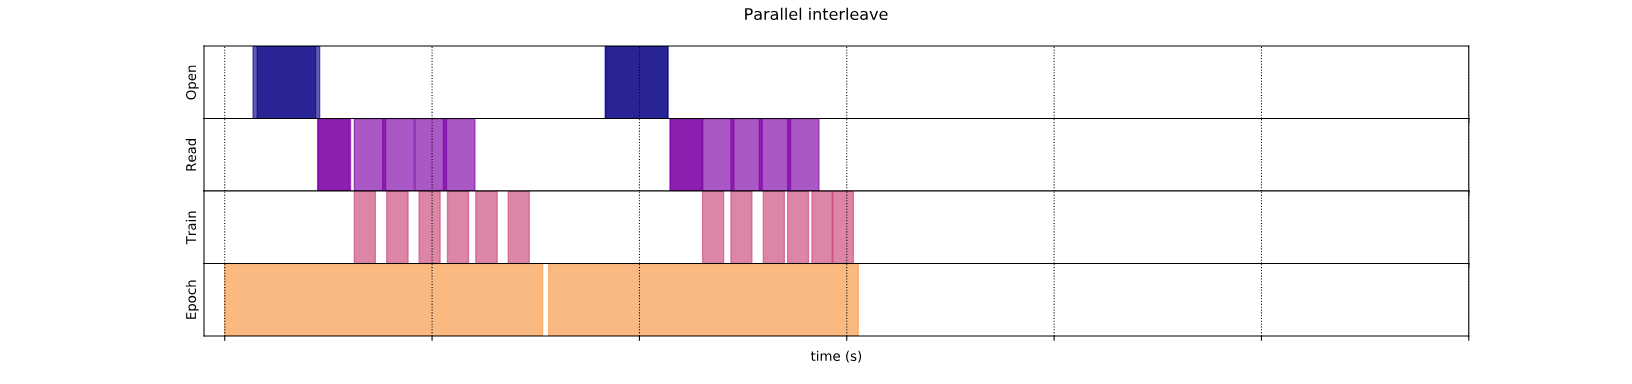

### 데이터 변환 병렬

입력 요소를 전처리할 때, map을 사용해 데이터세트의 각 요소에 사용자 정의 함수를 적용할 수 있다. prefetch와 interleave와 마찬가지로, map 역시 num_parallel_calls로 병렬처리의 수준을 정할 수 있다. (사용가능한 CPU 코어 수를 사용해도 되지만, 어지간하면 data.AUTOTUNE으로 해결할 수 있다. 컴퓨터가 자동으로 해주는데 굳이 사람이 할 이유가?)

In [33]:
def mapped_function(s):
    tf.py_function(lambda: time.sleep(0.03), [], ())
    return s

In [36]:
benchmark(ArtificialDataset().map(mapped_function))
benchmark(ArtificialDataset().map(mapped_function, num_parallel_calls=tf.data.AUTOTUNE))

Execution time: 0.6443989999997939
Execution time: 0.4113249000001815


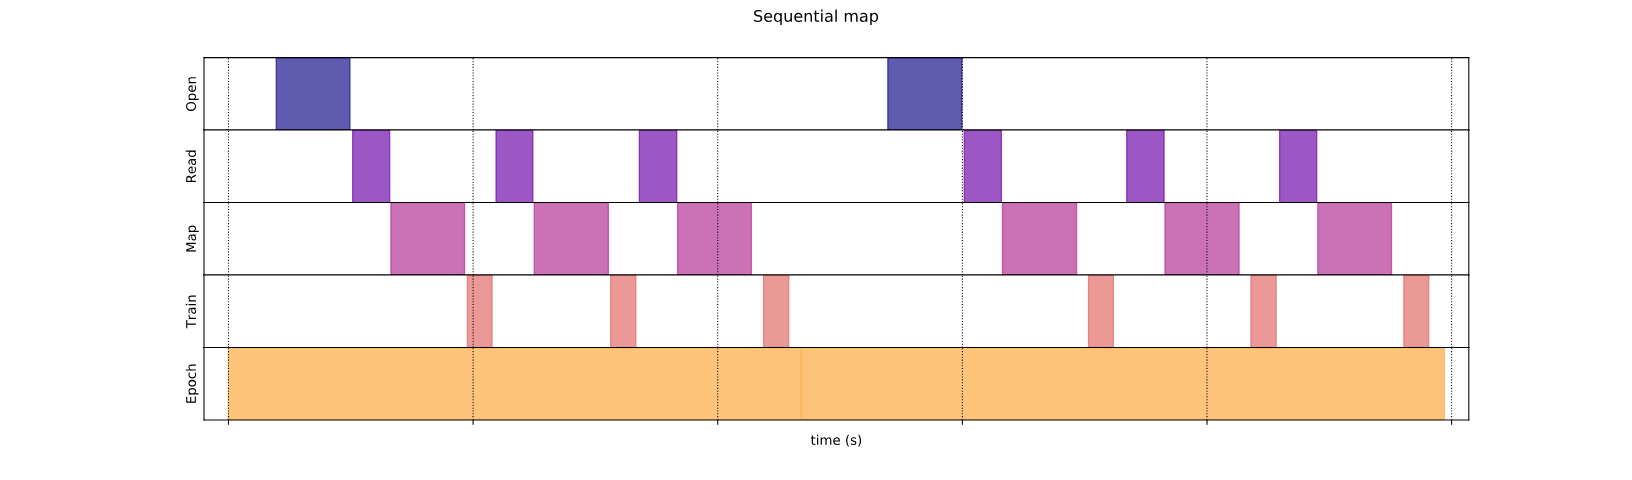
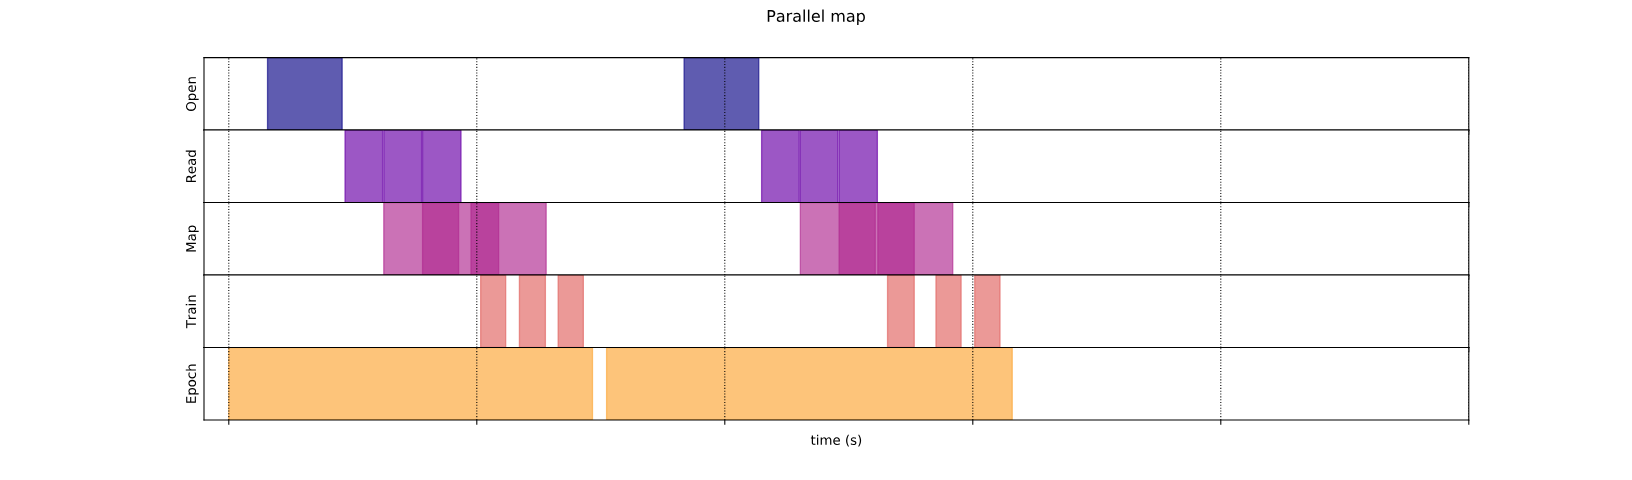

그림에서 볼 수 있듯, 기본으로 순차적 처리를 하게 되면 데이터를 열고, 읽고, 훈련하는 사이에 전처리 과정이 하나씩 끼어들게 된다. 즉, 시간이 많이 늘어나게 된다.

반면 병렬 처리를 수행하면, 데이터를 읽으면서도 동시에 여러 데이터를 처리할 수 있게 되므로 전체 시간이 줄어들게 된다.

### 캐시

데이터셋을 메모리 또는 로컬 저장소에 캐시할 수 있다. 이렇게 하면 에포크 동안 실행되는 파일 열기 및 데이터 읽기가 저장된다. 

그렇다면 이걸 왜 저장하는가?

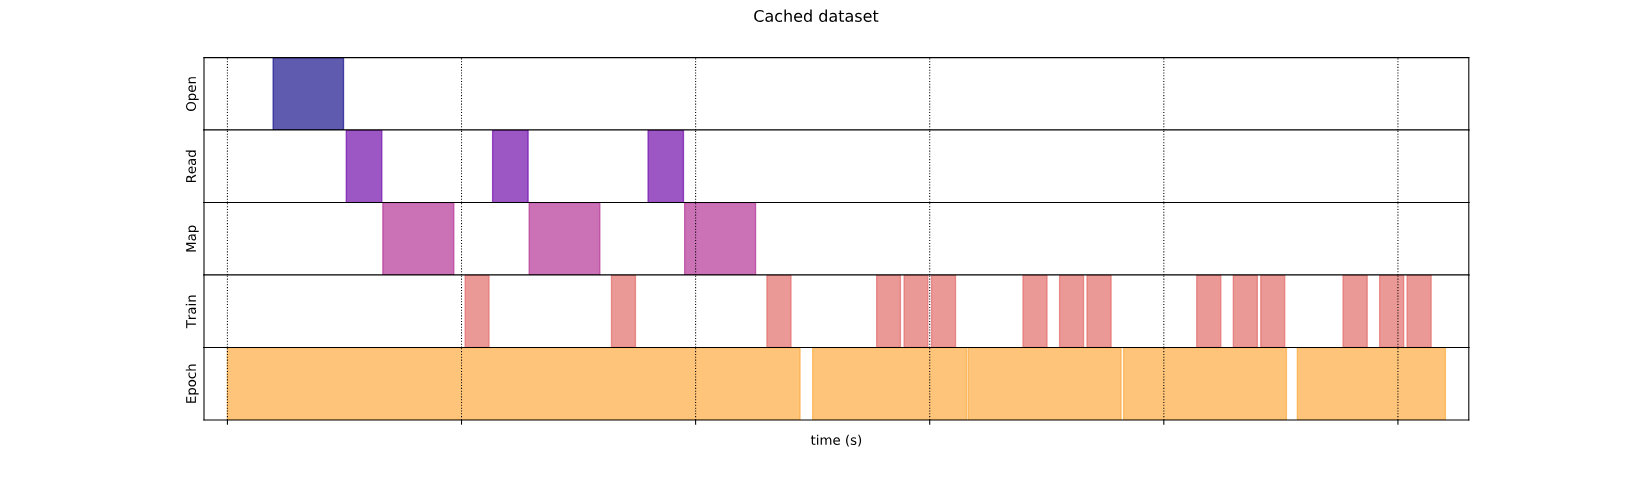

즉, 캐시에서 변환한 정보를 메모리에 저장해두면 매번 다시 데이터를 열 필요가 없어진다. 다음 에폭에서는 첫 에폭 동안에 캐시에 저장된 데이터 정보를 재사용하면 되기 때문이다.

In [38]:
benchmark(ArtificialDataset().map(mapped_function).cache(), 5)
benchmark(ArtificialDataset().map(mapped_function, num_parallel_calls=tf.data.AUTOTUNE).cache(), 5)

# 볼 수 있듯, 미리 캐싱이 이뤄지면 5번 데이터셋을 반복해도 거의 위의 2 에폭 시간과 비슷해진다.
# 또한 위에서 작성한 데이터 변환들은 같이 수행할 수 있다.

Execution time: 0.5467497999998159
Execution time: 0.382377699999779


### 매핑 벡터화

map 변환으로 전달된 사용자 정의 함수를 호출하면, 사용자 정의 함수의 스케줄링 및 실행에 관련된 오버헤드가 발생한다.

* 오버헤드 : 어떤 처리를 하기 위해 들어가는 간접적인 처리 시간, 메모리

그러니까 사용자 정의 함수를 사용해 데이터를 변환하면 당연히 함수를 실행하는데 추가시간이 들어간다는 것이다. 이를 예방하기 위해서 사용자 정의 함수 자체를 벡터화하고, 변환 전에 배치 변환을 적용하는 것이 좋다.

In [39]:
fast_dataset = tf.data.Dataset.range(10000)

def fast_benchmark(dataset, num_epochs=2):
    start_time = time.perf_counter()
    for _ in tf.data.Dataset.range(num_epochs):
        for _ in dataset:
            pass
    tf.print('Execution time:', time.perf_counter() - start_time)
    
def increment(x):
    return x + 1

In [40]:
# 먼저 사용자 함수를 스칼라 형태로 맵 변환

fast_benchmark(fast_dataset.map(increment).batch(256))

Execution time: 0.14471989999947255


In [41]:
fast_benchmark(fast_dataset.batch(256).map(increment))

Execution time: 0.041707299999870884


즉, 위와 아래의 차이는 함수를 적용하고 배치를 나눌 것이냐, 배치를 나누고 함수를 적용할 것이냐의 차이이다. 

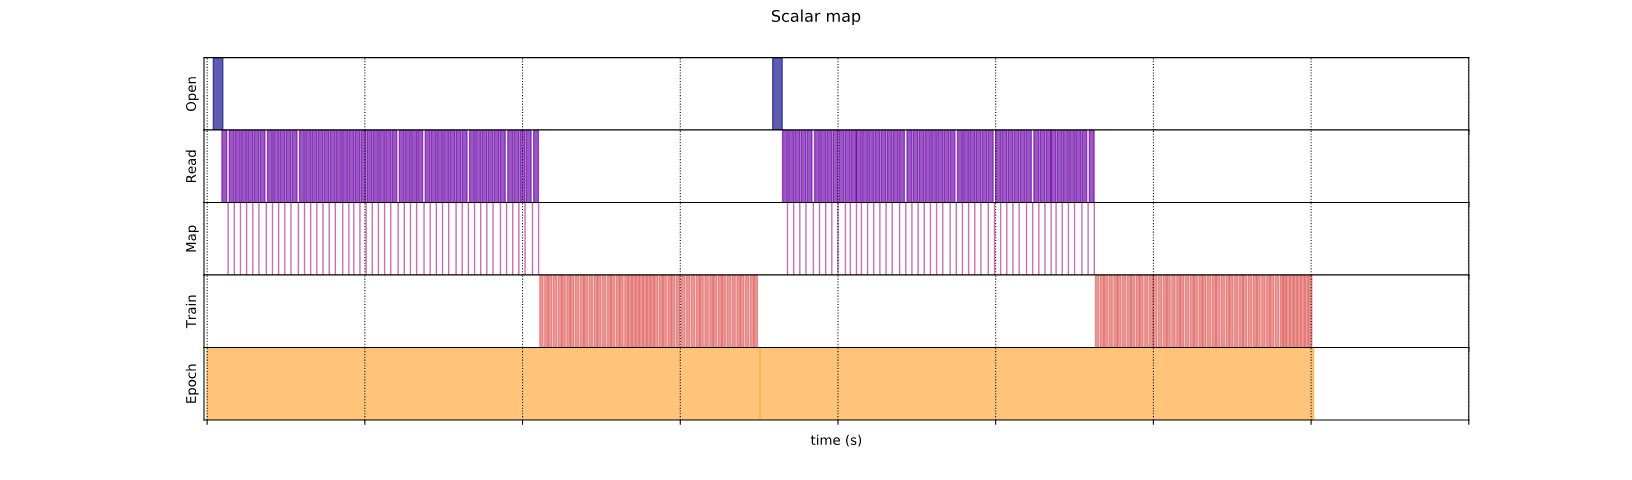
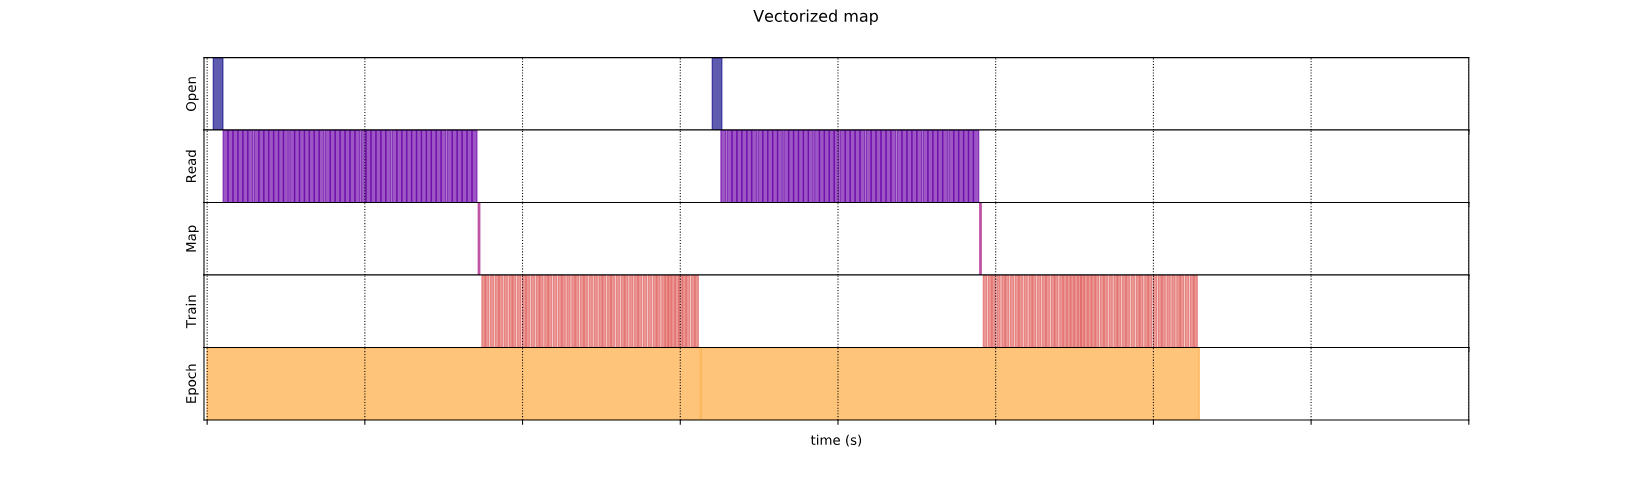

그러니까, 앞에서 fast_dataset에 매핑된 개체에 배치를 넣게 되면, 각 배치별로 매핑을 수행하게 된다. 

반면, 배치를 먼저 나누고 매핑을 하게 되면, 이 나눠진 데이터셋에 한 번에 매핑을 적용시킨다. 한 번의 매핑은 더 길겠지만, 전체 데이터에 매핑을 적용하는 형태이므로 한 번만 등장하기 때문에 걸리는 시간은 더 짧다.

## 메모리 사용량 줄이기

위에서 볼 수 있듯, interleave, prefetch, shuffle, map 등의 변환은 그 순서에 따라 메모리에 영향을 줄 수 있다. 당연히 메모리 사용량이 낮은 순서로 변환을 수행해야 할 것이다.

### 부분 계산 캐싱

dataset.map(time_consuming_mapping).cache().map(memory_consuming_mapping)

즉, 시간이 많이 걸리는 부분은 앞에, 메모리가 많이 드는 부분은 뒤에 배치하면 데이터셋 변환을 최적화할 수 있다.

### 요약

    * prefetch를 통해 데이터셋 호출 오버랩
    * interleave 변환을 통해 데이터 읽기 병렬화
    * num_parallel_calls 매개변수로 매핑 병렬화
    * 메모리에 저장이 가능하다면 cache 변환으로 데이터 캐싱
    * map 변환은 벡터화
    * 적절한 변환 적용으로 메모리 사용 최소화

그 외에도 모든 병렬 수행이 가능한 변환은 num_parallel_calls를 지정해줄 수 있고, 해당 부분은 AUTOTUNE에 맡기면 된다

### 파이프라인 시각화

In [42]:
import itertools
from collections import defaultdict

import numpy as np
import matplotlib as mpl
import matplotlib.pyplot as plt

### 예시 데이터셋

각 단계에서 소요된 시간을 리턴하는 데이터셋을 제너레이터를 통해 생성한다.

In [61]:
class TimeMeasuredDataset(tf.data.Dataset):
    # OUTPUT: (steps, timings, counters)
    OUTPUT_TYPES = (tf.dtypes.string, tf.dtypes.float32, tf.dtypes.int32)
    OUTPUT_SHAPES = ((2, 1), (2, 2), (2, 3))

    _INSTANCES_COUNTER = itertools.count()  # Number of datasets generated
    _EPOCHS_COUNTER = defaultdict(itertools.count)  # Number of epochs done for each dataset

    def _generator(instance_idx, num_samples):
        epoch_idx = next(TimeMeasuredDataset._EPOCHS_COUNTER[instance_idx])

        # Opening the file
        open_enter = time.perf_counter()
        time.sleep(0.03)
        open_elapsed = time.perf_counter() - open_enter

        for sample_idx in range(num_samples):
            # Reading data (line, record) from the file
            read_enter = time.perf_counter()
            time.sleep(0.015)
            read_elapsed = time.perf_counter() - read_enter

            yield (
                [("Open",), ("Read",)],
                [(open_enter, open_elapsed), (read_enter, read_elapsed)],
                [(instance_idx, epoch_idx, -1), (instance_idx, epoch_idx, sample_idx)]
            )
            open_enter, open_elapsed = -1., -1.  # Negative values will be filtered


    def __new__(cls, num_samples=3):
        return tf.data.Dataset.from_generator(
            cls._generator,
            output_types=cls.OUTPUT_TYPES,
            output_shapes=cls.OUTPUT_SHAPES,
            args=(next(cls._INSTANCES_COUNTER), num_samples)
        )

### 반복 루프

반복 루프를 통해 시간 집계 (위의 데이터셋에 맞게 하드코딩 되어있다.)

In [44]:
def timelined_benchmark(dataset, num_epochs=2):
    # 집계 초기화
    steps_acc = tf.zeros([0, 1], dtype=tf.dtypes.string)
    times_acc = tf.zeros([0, 2], dtype=tf.dtypes.float32)
    values_acc = tf.zeros([0, 3], dtype=tf.dtypes.int32)
    start_time = time.perf_counter()
    
    for epoch_num in range(num_epochs):
        epoch_enter = time.perf_counter()
        for (steps, times, values) in dataset:
            # 데이터셋 준비 정보
            steps_acc = tf.concat((steps_acc, steps), axis=0)
            times_acc = tf.concat((times_acc, times), axis=0)
            values_acc = tf.concat((values_acc, values), axis=0)
            
            # 훈련 시간 시뮬레이팅
            train_enter = time.perf_counter()
            time.sleep(0.01)
            train_elapsed = time.perf_counter() - train_enter
            
            # 훈련 정보 기록
            steps_acc = tf.concat((steps_acc, [["Train"]]), axis=0)
            times_acc = tf.concat((times_acc, [(train_enter, train_elapsed)]), axis=0)
            values_acc = tf.concat((values_acc, [values[-1]]), axis=0)
            
        epoch_elapsed = time.perf_counter() - epoch_enter
        # 에폭 정보 기록
        steps_acc = tf.concat((steps_acc, [['Epoch']]), axis=0)
        times_acc = tf.concat((times_acc, [(epoch_enter, epoch_elapsed)]), axis=0)
        values_acc = tf.concat((values_acc, [[-1, epoch_num, -1]]), axis=0)
        time.sleep(0.001)
    
    tf.print('Execution time:', time.perf_counter() - start_time)
    return {"steps": steps_acc, "times": times_acc, "values": values_acc}

### 타임라인 시각화 함수

위의 함수에 의해 리턴된 값을 시각화할 수 있도록 함수를 설계한다.

In [65]:
def draw_timeline(timeline, title, width=0.5, annotate=False, save=False):
    # 불필요한 정보 삭제
    invalid_mask = np.logical_and(timeline['times']>0, timeline['steps']!=b'')[:, 0]
    steps = timeline['steps'][invalid_mask].numpy()
    times = timeline['times'][invalid_mask].numpy()
    values = timeline['values'][invalid_mask].numpy()
    
    # 조우 순으로 정렬된 스텝의 집합
    step_ids, indices = np.stack(np.unique(steps, return_index=True))
    step_ids = step_ids[np.argsort(indices)]
    
    # 시작 시점 0으로 전환하고 최대 시간 측정
    min_time = times[:,0].min()
    times[:,0] = (times[:,0] - min_time)
    end = max(width, (times[:,0]+ times[:,1]).max() + 0.01)
    
    cmap = mpl.cm.get_cmap('plasma')
    plt.close()
    fig, axs = plt.subplots(len(step_ids), sharex=True, gridspec_kw={'hspace':0})
    fig.suptitle(title)
    fig.set_size_inches(17.0, len(step_ids))
    plt.xlim(-0.01, end)
    
    for i, step in enumerate(step_ids):
        step_name = step.decode()
        ax = axs[i]
        ax.set_ylabel(step_name)
        ax.set_ylim(0, 1)
        ax.set_yticks([])
        ax.set_xlabel("time (s)")
        ax.set_xticklabels([])
        ax.grid(which = 'both', axis= 'x', color= 'k', linestyle=':')
        
        # 해당 스텝의 시간과 주석 가져오기
        entries_mask = np.squeeze(steps==step)
        serie = np.unique(times[entries_mask], axis=0)
        annotations = values[entries_mask]
        
        ax.broken_barh(serie, (0, 1), color=cmap(i / len(step_ids)), linewidth=1, alpha=0.6)
        if annotate:
            for j, (start, width) in enumerate(serie):
                annotation = '\n'.join([f'{l}: {v}' for l, v in zip(('i', 'e', 's'), annotations[j])])
                ax.text(start + 0.001 + (0.001 * (j % 2)), 0.55 - (0.1 * (j % 2)), annotation,
                       horizontalalignment='left', verticalalignment='center')
    if save:
        plt.savefig(title.lower().translate(str.maketrans(" ", "_"))+".png")

### 매핑된 함수 래퍼

In [46]:
def map_decorator(func):
    def wrapper(steps, times, values):
        return tf.py_function(
        func,
        inp=(steps, times, values),
        Tout = (steps.dtype, times.dtype, values.dtype))
    return wrapper

### 파이프라인

In [48]:
_batch_map_num_items = 50

def dataset_generator_fun(*args):
    return TimeMeasuredDataset(num_samples=_batch_map_num_items)

#### 일반 배치 호출의 경우

In [62]:
@map_decorator
def naive_map(steps, times, values):
    map_enter = time.perf_counter()
    time.sleep(0.001)  # Time consuming step
    time.sleep(0.0001)  # Memory consuming step
    map_elapsed = time.perf_counter() - map_enter

    return (
        tf.concat((steps, [["Map"]]), axis=0),
        tf.concat((times, [[map_enter, map_elapsed]]), axis=0),
        tf.concat((values, [values[-1]]), axis=0)
    )

naive_timeline = timelined_benchmark(
    tf.data.Dataset.range(2)
    .flat_map(dataset_generator_fun)
    .map(naive_map)
    .batch(_batch_map_num_items, drop_remainder=True)
    .unbatch(),
    5
)

Instructions for updating:
Use output_signature instead
Instructions for updating:
Use output_signature instead
Execution time: 37.84263789999932


C:\Users\donga\AppData\Local\Temp\ipykernel_8920\2366872823.py:17: MatplotlibDeprecationWarning: The get_cmap function was deprecated in Matplotlib 3.7 and will be removed two minor releases later. Use ``matplotlib.colormaps[name]`` or ``matplotlib.colormaps.get_cmap(obj)`` instead.
  cmap = mpl.cm.get_cmap('plasma')


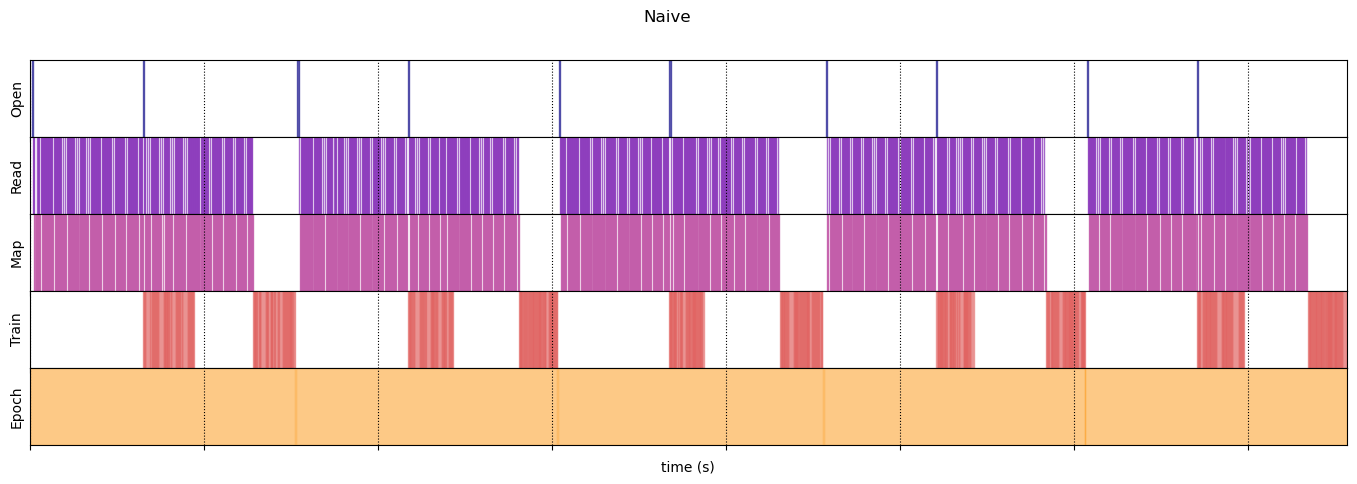

In [66]:
draw_timeline(naive_timeline, "Naive", 15, save=True)

#### 메모리 최적화된 데이터셋 호출

In [67]:
@map_decorator
def time_consuming_map(steps, times, values):
    map_enter = time.perf_counter()
    time.sleep(0.001 * values.shape[0])  # Time consuming step
    map_elapsed = time.perf_counter() - map_enter

    return (
        tf.concat((steps, tf.tile([[["1st map"]]], [steps.shape[0], 1, 1])), axis=1),
        tf.concat((times, tf.tile([[[map_enter, map_elapsed]]], [times.shape[0], 1, 1])), axis=1),
        tf.concat((values, tf.tile([[values[:][-1][0]]], [values.shape[0], 1, 1])), axis=1)
    )


@map_decorator
def memory_consuming_map(steps, times, values):
    map_enter = time.perf_counter()
    time.sleep(0.0001 * values.shape[0])  # Memory consuming step
    map_elapsed = time.perf_counter() - map_enter

    # Use tf.tile to handle batch dimension
    return (
        tf.concat((steps, tf.tile([[["2nd map"]]], [steps.shape[0], 1, 1])), axis=1),
        tf.concat((times, tf.tile([[[map_enter, map_elapsed]]], [times.shape[0], 1, 1])), axis=1),
        tf.concat((values, tf.tile([[values[:][-1][0]]], [values.shape[0], 1, 1])), axis=1)
    )


optimized_timeline = timelined_benchmark(
    tf.data.Dataset.range(2)
    .interleave(  # Parallelize data reading
        dataset_generator_fun,
        num_parallel_calls=tf.data.AUTOTUNE
    )
    .batch(  # Vectorize your mapped function
        _batch_map_num_items,
        drop_remainder=True)
    .map(  # Parallelize map transformation
        time_consuming_map,
        num_parallel_calls=tf.data.AUTOTUNE
    )
    .cache()  # Cache data
    .map(  # Reduce memory usage
        memory_consuming_map,
        num_parallel_calls=tf.data.AUTOTUNE
    )
    .prefetch(  # Overlap producer and consumer works
        tf.data.AUTOTUNE
    )
    .unbatch(),
    5
)

Execution time: 10.591817500000616


C:\Users\donga\AppData\Local\Temp\ipykernel_8920\2366872823.py:17: MatplotlibDeprecationWarning: The get_cmap function was deprecated in Matplotlib 3.7 and will be removed two minor releases later. Use ``matplotlib.colormaps[name]`` or ``matplotlib.colormaps.get_cmap(obj)`` instead.
  cmap = mpl.cm.get_cmap('plasma')


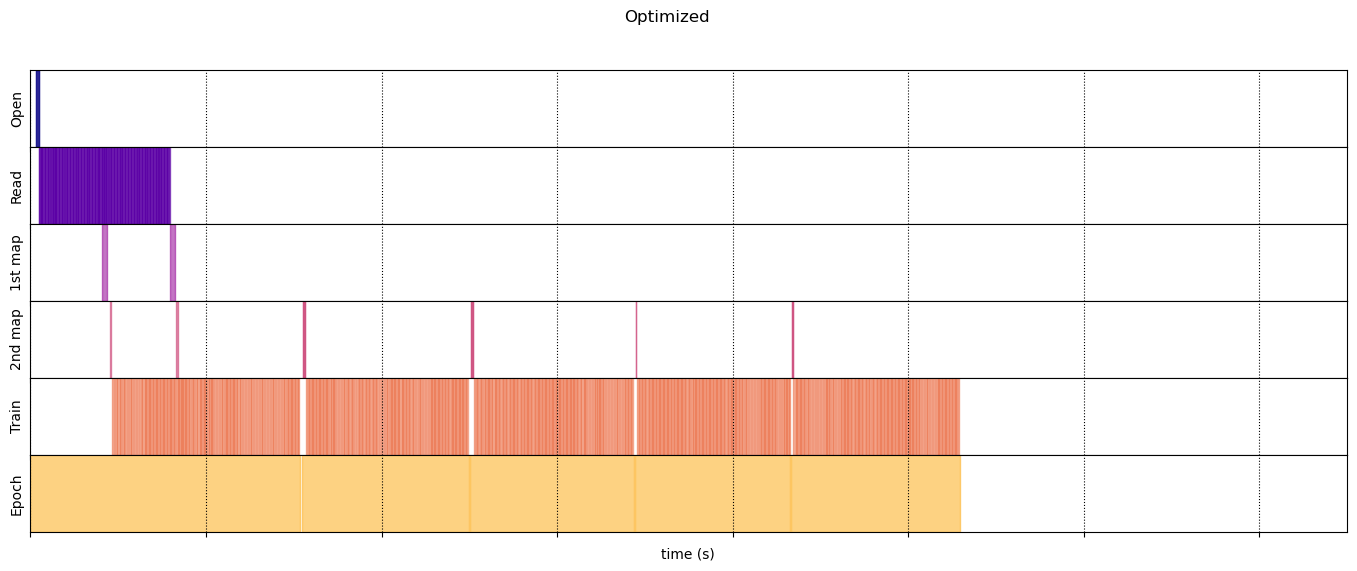

In [69]:
draw_timeline(optimized_timeline, "Optimized", 15, save=True)

이렇듯, 데이터셋을 로드하는 방식은 전체 훈련 시간에 큰 차이를 줄 수 있다. interleave, batch, map, cache, prefetch 등 여러 방법을 사용해 메모리에 가해지는 부담을 줄여보자.